# Neural Art Transfer

### 1. Setup and Imports

First, we'll import the necessary libraries. We need **`torch`** and its submodules `nn` and `optim` for building the model and for optimization. We'll use **`torchvision`** for its pre-trained models and image transformations. For handling images, we'll use the **`PIL`** (Pillow) library, and **`matplotlib`** will be used for displaying them.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import urllib

In [10]:
#Checking for GPU and setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. Load and Preprocess Images

Next, we need our **content image** and **style image**. We'll download two example images. We then define a transformation pipeline using `torchvision.transforms` to resize the images, convert them to PyTorch tensors, and normalize them with the specific mean and standard deviation values that the pre-trained VGG model expects.

In [11]:
#Downloading images
urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg", "turtle.jpg")
urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg", "kandinsky.jpg")

('kandinsky.jpg', <http.client.HTTPMessage at 0x786e902768b0>)

In [12]:
#Defining image transformations
imsize = 512 if torch.cuda.is_available() else 256  #Using smaller size on CPU
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),
    # The VGG models were trained on images normalized this way
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def image_loader(image_name):
    """Loads an image, applies transformations, and adds a batch dimension."""
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_image = image_loader("turtle.jpg")
style_image = image_loader("kandinsky.jpg")

#Quick-checking to ensure the tensors have the correct shape
print(f"Content image shape: {content_image.shape}")
print(f"Style image shape: {style_image.shape}")

Content image shape: torch.Size([1, 3, 512, 512])
Style image shape: torch.Size([1, 3, 512, 512])


### 3. Define the Model and Feature Layers

We'll use a pre-trained **VGG19** model from `torchvision`. We only need the feature extraction layers (convolutional and pooling), not the final classifier. We'll create a custom model that captures the outputs from the specific convolutional layers needed to calculate content and style loss.

* **Content Layer**: A deeper layer (`conv_4`) captures the main objects.
* **Style Layers**: A mix of layers captures textures at different scales.

In [13]:
#Loading the pre-trained VGG19 model's feature extraction part
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

def get_style_model_and_losses(cnn, style_img, content_img):
    """
    Builds a new model by adding content and style loss "layers" after the
    specified layers of the input cnn.
    """
    content_layers = [22]  #relu4_2
    style_layers = [1, 6, 11, 20, 29]  #relu1_1, relu2_1, relu3_1, relu4_1, relu5_1

    model = nn.Sequential()
    content_losses = []
    style_losses = []

    i = 0  #layer index
    for layer in cnn.children():
        #Inplace ReLU layers can cause issues, so replacing them
        if isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)

        model.add_module(str(i), layer)

        if i in content_layers:
            #Adding content loss layer
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if i in style_layers:
            #Adding style loss layer
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

        i += 1

    #Trimming off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

### 4. Define Loss Functions

Here we define the custom loss modules. The total loss is a weighted sum of the content and style losses.

* **`ContentLoss`**: This is a mean squared error between the feature maps of the content image and the generated image.
* **`StyleLoss`**: This calculates a **Gram matrix** (representing feature correlations) for both the style and generated images. The loss is the mean squared error between these two Gram matrices.

In [14]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        #detaching the target from the tree used to compute the gradient
        #as it is a fixed value, not a variable.
        self.target = target.detach()
        self.loss = None

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        #returning the input so this module can be used as a transparent layer.
        return input

def gram_matrix(input):
    """Computes the Gram matrix for a batch of feature maps."""
    b, c, h, w = input.size()  #b=batch size(=1)
                               #c=number of feature maps
                               #(h,w)=dimensions of a f. map (N=h*w)
    features = input.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))  #computing the gram product
    #normalizing the values of the gram matrix
    #by dividing by the number of element in each feature maps.
    return G.div(c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = None

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

### 5. The Optimization Loop

Here's the main training loop. We start with a copy of the content image and use an optimizer (Adam works well) to iteratively update its pixels. In each step, we calculate the total loss and use backpropagation to adjust the image to minimize this loss.

In [15]:
#Initializing the generated image as a clone of the content image
generated_image = content_image.clone().requires_grad_(True)

#Using Adam optimizer
optimizer = optim.Adam([generated_image], lr=0.03)

#Defining loss weights
style_weight = 1000000
content_weight = 1

#Running the Optimization
print("Building the style transfer model...")
model, style_losses, content_losses = get_style_model_and_losses(vgg, style_image, content_image)

print("Optimizing...")
num_steps = 300
run = [0]
while run[0] <= num_steps:

    def closure():
        #Correcting the values of the generated image to be between 0 and 1
        with torch.no_grad():
            generated_image.clamp_(0, 1)

        optimizer.zero_grad()
        model(generated_image)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)

        #Applying weights
        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"run {run[0]}:")
            print(f"Style Loss: {style_score.item():.4f} Content Loss: {content_score.item():.4f}")

        return loss

    optimizer.step(closure)

#Final clamp to ensure values are valid
with torch.no_grad():
    generated_image.clamp_(0, 1)

Building the style transfer model...
Optimizing...
run 50:
Style Loss: 56.5884 Content Loss: 8.1699
run 100:
Style Loss: 35.4960 Content Loss: 7.6517
run 150:
Style Loss: 29.6261 Content Loss: 7.3384
run 200:
Style Loss: 26.8136 Content Loss: 7.1367
run 250:
Style Loss: 25.1663 Content Loss: 6.9957
run 300:
Style Loss: 24.0719 Content Loss: 6.8856


### 6. Final Output

After the optimization loop, the `generated_image` tensor holds our result. We need to convert it back into a displayable image. This involves reversing the normalization process and transforming the tensor into a format that `matplotlib` can show.

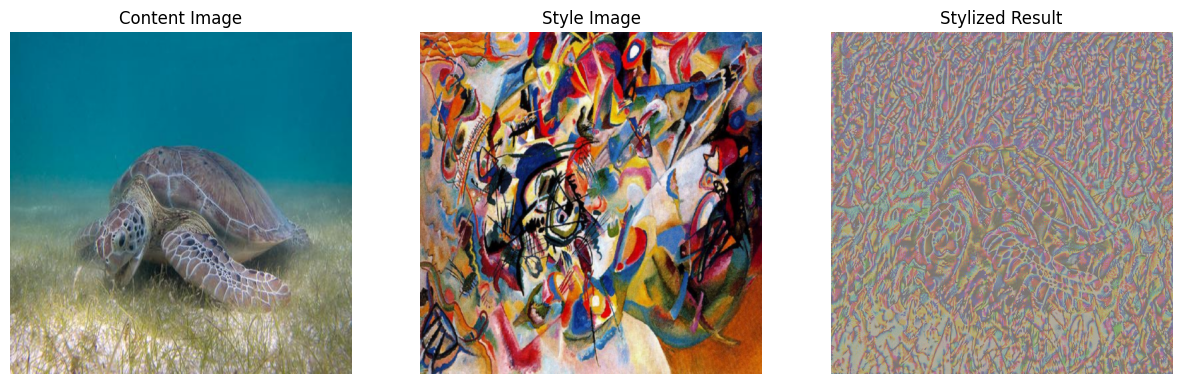

In [16]:
#Function to un-normalize and display an image tensor
def imshow(tensor, title=None):
    image = tensor.cpu().clone() #Cloning the tensor to not do changes on it
    image = image.squeeze(0) #Removing the fake batch dimension
    
    #Reversing the normalization
    unloader = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ])
    image = unloader(image)
    image = image.clamp(0, 1)
    
    #Converting to a PIL image and then display
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

#Displaying the final results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
imshow(content_image, title='Content Image')

plt.subplot(1, 3, 2)
imshow(style_image, title='Style Image')

plt.subplot(1, 3, 3)
imshow(generated_image, title='Stylized Result')

plt.show()